In [7]:
from scipy.stats import (
    binom
)
import numpy as np
from seaborn import distplot
from matplotlib import pyplot as plt
import seaborn
import random
from tqdm.notebook import tqdm

import sys
sys.path.append('.')

In [9]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in plt.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = plt.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    plt.rcParams.update(update_dict)
    plt.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = plt.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    plt.rcParams['legend.edgecolor'] = lec

In [10]:
inverse_plot_colorscheme()

Помимо ошибки первого рода(FPR) важно смотреть и на ошибку второго рода(FNR), так как очень легко придумать критерий сколько угодно малой стат значимости - берём бернулевскую случайную величину с вероятностью успеха $\alpha$, если выпал успех, то отвергаем H0, если неудача - не отвергаем

У такого критерия FNR - вероятность не отвергать H0, хотя на самом деле верна H1, составляет $1-\alpha$ - достаточно большое число при малых $\alpha$, это не есть хорошо

Поэтому при анализе критерия необходимо обращать внимание не только на FPR

В статистике принято работать не с FNR, а с так называемой мощностью    
$$ \text{Power}_S = 1 - FNR $$

Если альтернатива H1 состоит из множества исходов, то мощность - функция от исхода

$$ \text{Power}_S(\mu) = 1 - FNR(\mu) $$

В задаче с доставками из прошлой главы исходы - это истинное значение вероятности того, что клиент не откажется от доставки

Попробуем посчитать мощность для задачи с доставками  при следующих гипотезах

$$
H0: \mu = 0.5
$$
$$
H1: \mu = 0.6
$$

In [11]:
binom_h0 = binom(n=30, p=0.5)
binom_h1 = binom(n=30, p=0.6)

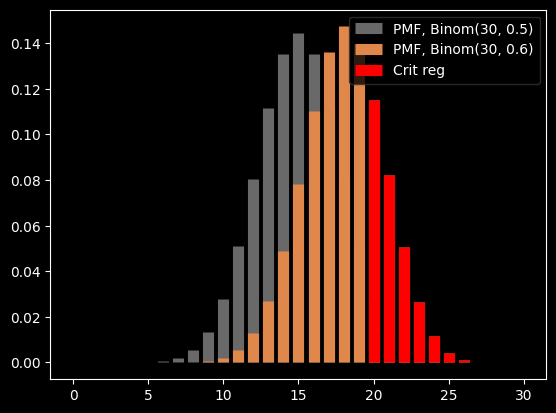

In [12]:
x_grid = np.arange(0, 31)
crit_value = 20
crit_reg = (x_grid >= crit_value)

fig = plt.figure()
ax = plt.axes()

ax.vlines(x_grid, 0, binom_h0.pmf(x_grid), color='lightgrey', linewidth=8, label='PMF, Binom(30, 0.5)', alpha=0.5)
ax.vlines(x_grid, 0, binom_h1.pmf(x_grid), linewidth=8, label='PMF, Binom(30, 0.6)')
ax.vlines(x_grid[crit_reg], 0, binom_h1.pmf(x_grid[crit_reg]), color='red', linewidth=8, label='Crit reg')

ax.legend()

FNR - это вероятность ошибочно принять H1, то есть P(Q < 20| H1), тогда Power = P(Q >= 20|H1)

In [14]:
power = 1 - binom_h1.cdf(crit_value - 1)
power

np.float64(0.2914718612234968)

Решим задачу в общем случае

In [20]:
def plot_draw(N, mu_h0, mu_h1, alpha=0.05):
    binom_h0 = binom(n=N, p=mu_h0)
    binom_h1 = binom(n=N, p=mu_h1)

    crit_val = binom_h0.ppf(1 - alpha) + 1

    x_grid = np.arange(N + 1)
    crit_reg = (x_grid >= crit_value)

    fig = plt.figure()
    ax = plt.axes()

    ax.vlines(x_grid, 0, binom_h0.pmf(x_grid), color='lightgrey', linewidth=8, label=f'PMF, Binom({N}, {mu_h0})', alpha=0.5)
    ax.vlines(x_grid, 0, binom_h1.pmf(x_grid), linewidth=8, label=f'PMF, Binom({N}, {mu_h1})')
    ax.vlines(x_grid[crit_reg], 0, binom_h1.pmf(x_grid[crit_reg]), color='red', linewidth=8, label='Crit reg')

    ax.legend()



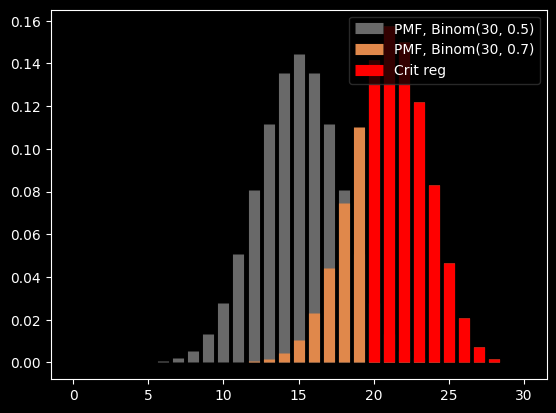

In [21]:
plot_draw(30, 0.5, 0.7)

In [23]:
def get_power(N, mu_h0, mu_h1, alpha=0.05):
    binom_h0 = binom(n=N, p=mu_h0)
    binom_h1 = binom(n=N, p=mu_h1)

    crit_val = binom_h0.ppf(1 - alpha) + 1
    return 1 - binom_h1.cdf(crit_val - 1)

In [24]:
get_power(30, 0.5, 0.7)

np.float64(0.7303703863027231)

In [25]:
get_power(300, 0.5, 0.7)

np.float64(0.9999999842704518)

In [26]:
get_power(300, 0.5, 0.6)

np.float64(0.9655326717180749)

Посмотрим как будет меняться мощность при увеличение N

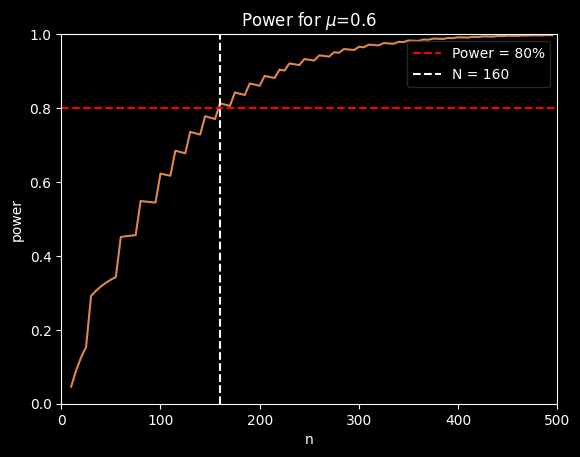

In [53]:
n_grid = np.arange(10, 500, 5)
power = get_power(n_grid, 0.5, 0.6)

fig = plt.figure()
ax = plt.axes()

ax.set_title('Power for $\\mu$=0.6')
ax.set_xlabel('n')
ax.set_ylabel('power')

ax.set_xlim(0, 500)
ax.set_ylim(0, 1)

ax.plot(n_grid, power)

min_n = n_grid[power >= 0.8].min()
ax.axhline(0.8, ls='--', color='red', label='Power = 80%')
ax.axvline(min_n, ls='--', color='white', label = f'N = {min_n}')

ax.legend()

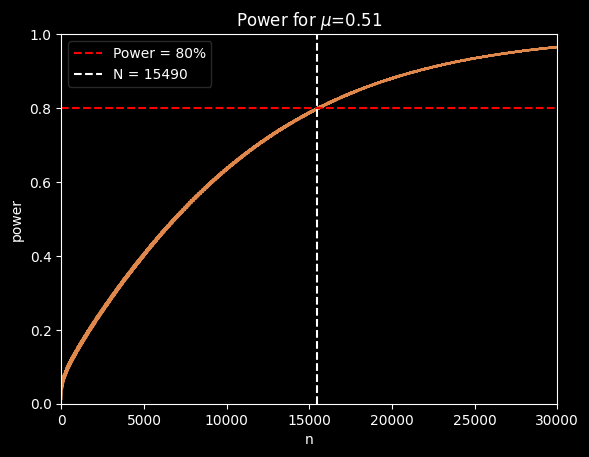

In [59]:
n_grid = np.arange(10, 30000, 5)
power = get_power(n_grid, 0.5, 0.51)

fig = plt.figure()
ax = plt.axes()

ax.set_title('Power for $\\mu$=0.51')
ax.set_xlabel('n')
ax.set_ylabel('power')

ax.set_xlim(0, 30000)
ax.set_ylim(0, 1)

ax.plot(n_grid, power)

min_n = n_grid[power >= 0.8].min()
ax.axhline(0.8, ls='--', color='red', label='Power = 80%')
ax.axvline(min_n, ls='--', color='white', label = f'N = {min_n}')

ax.legend()

Теперь посмотрим как будет меняться мощность при фиксированном N для разных значений параметра $\mu1$

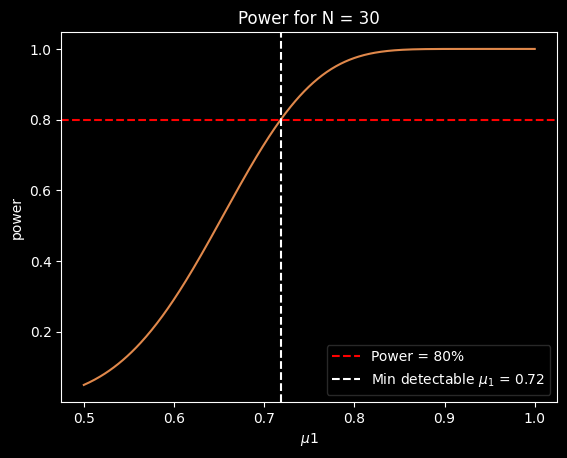

In [67]:
mu_grid = np.linspace(0.5, 1, 500)
power = get_power(30, 0.5, mu_grid)

fig, ax = plt.figure(), plt.axes()

ax.set_xlabel('$\\mu1$')
ax.set_ylabel('power')
ax.set_title('Power for N = 30')

ax.plot(mu_grid, power)

mu_min = mu_grid[power >= 0.8].min()
ax.axhline(0.8, ls='--', color='red', label='Power = 80%')
ax.axvline(mu_min, ls='--', color='white', label=f'Min detectable $\\mu_1$ = {np.round(mu_min, 2)}')

ax.legend()

Анализируя полученные наблюдения, возникает желание как-то отметить такое значение $\mu_1 = 0.72$

MDE - minimal detectable effect, минимальный детектируемый эффект - минимальное изменение значения метрики, которое можно считать значимым для нашей задачи

В задаче выше MDE = +22 п.п. - 22 процентных пункта

Более формально, $MDE$ для гипотезы $\mathsf{H}_0: \mu = \mu_0$ &mdash; это минимальный эффект $\delta$, при котором критерий уровня значимости $\alpha$ для проверки этой гипотезы при истинном параметре $\mu = \mu_0 + \delta$ и размере выборки $N$ будет отвергать $\mathsf{H}_0$ с мощностью большей, чем $1 - \beta$

Напишем функцию, которая по нулевой гипотезе и размеру выборки вычисляет MDE

In [77]:
def get_mde(N, mu0, alpha=0.05, power=0.8):
    mu_grid = np.linspace(1 - mu0, 1,  500)
    power_grid = get_power(N, mu0, mu_grid, alpha)
    return round(100 * (mu_grid[power_grid >= power][0] - mu0), 2)

In [78]:
get_mde(30, 0.5)

np.float64(21.84)

In [79]:
get_mde(50, 0.5)

np.float64(18.54)

In [80]:
get_mde(500, 0.5)

np.float64(5.61)

Обычно решают обратную задачу, по MDE и приемлемой мощности ищут объём выборки

Из выборки можно получить больше информации, чем просто отвергать или не отвергать нулевую гипотезу

В задаче на доставки мы придумали механизм, который говорит нам можно ли объяснить конкретным значением параметра $\mu_0$ нашу выборку, или маловероятно

Тогда давайте найдём все значения $\mu_0$, для которых этот механизм говорит да

In [91]:
def get_interval(n, mu, alpha=0.05):
    binom_h0 = binom(n=n, p=mu)
    left = binom_h0.ppf(alpha / 2)
    right = binom_h0.ppf(1 - alpha / 2)
    return left, right

In [92]:
n = 30
success_cnt = 19
mu_grid = np.arange(0, 1, 0.001)
mu_no_rejected = []

for mu_h0 in mu_grid:
    left, right = get_interval(n, mu_h0)
    if left <= success_cnt <= right:
        mu_no_rejected.append(mu_h0)
print(mu_no_rejected[0], mu_no_rejected[-1])

0.439 0.8


Факт: с вероятностью в 95% истинное значение параметра находится в интервале [0.439, 0.8]

В общем случае: доверительный интервал уровня доверия $1 - \alpha$ - множество значение параметра $\mu_0$, для кторых гипотеза $\mu = \mu_0$ не отвергается критерием уровня значимости $\alpha$

In [95]:
left, right = get_interval(30, 0.5)
left, right = int(left), int(right)
binom(30, p=0.5).pmf(np.arange(31)[left:right + 1]).sum()

np.float64(0.9572260547429321)

Следующие картинки иллюстрируют что происходит

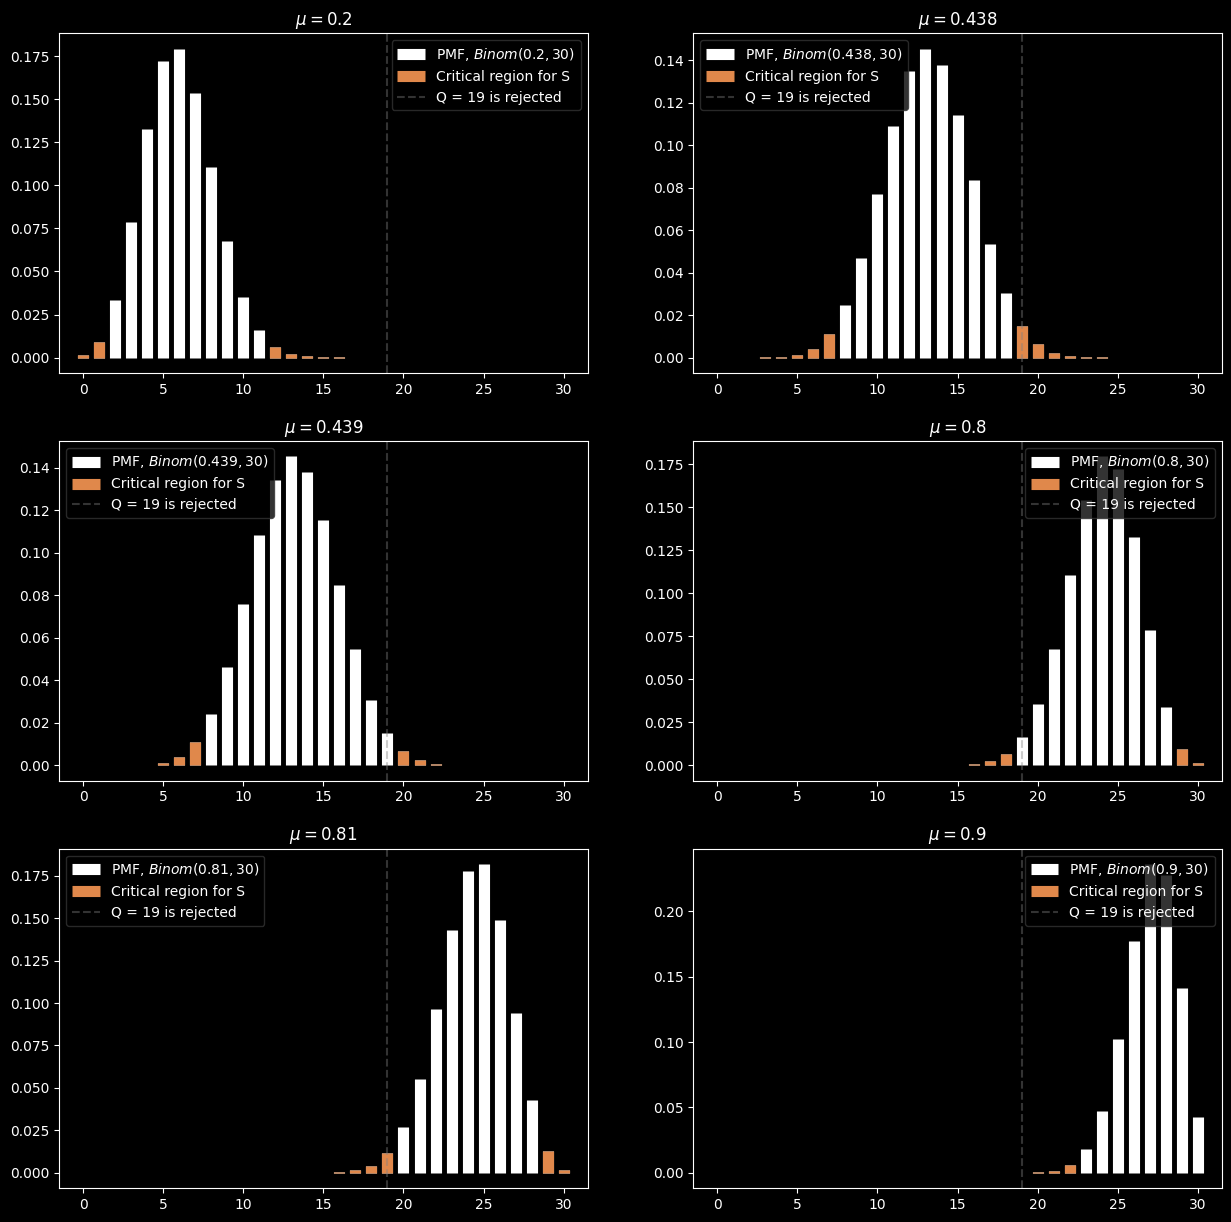

In [99]:
mus_h0 = [0.2, 0.438, 0.439, 0.8, 0.81, 0.9]
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for mu_h0, ax in zip(mus_h0, axes.flatten()):
    binom_h0 = binom(n=30, p=mu_h0)
    probs = binom_h0.pmf(x_grid)

    # строим вертикальные столбцы от 0 до вероятности
    ax.vlines(x_grid, 0, probs, linewidth=8.0, color='white', label=f'PMF, $Binom({mu_h0}, 30)$')
    # отдельно изобразим критическую области критерия
    c1, c2 = get_interval(30, mu_h0, alpha=0.05)
    crit_reg = (x_grid < c1) | (x_grid > c2)
    ax.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=8.0, label='Critical region for S')

    is_rejection = success_cnt <= c1 or success_cnt >= c2
    ax.axvline(success_cnt, ls='--', label=f'Q = {success_cnt} ' + ('is rejected' if is_rejection else 'is not rejected'), color='gray', alpha=0.4)

    rejection_prob = probs[crit_reg].sum()
    ax.set_title(f'$\\mu = {mu_h0}$', fontsize=12)
    ax.legend()


Выше мы строили двусторонний доверительный интервал, посторим теперь односторонний

In [100]:
def make_binom_criterion(n, mu=0.5, alpha=0.05):
    binom_h0 = binom(n=n, p=mu)
    q = binom_h0.ppf(1 - alpha)
    return q

In [101]:
success_cnt = 19
mu_grid = np.arange(0, 1.001, 0.001)
mu_no_rejection = []

for mu_h0 in mu_grid:
    crit_val = make_binom_criterion(n=30, mu=mu_h0, alpha=0.05)
    if success_cnt <= crit_val:
        mu_no_rejection.append(mu_h0)

print(mu_no_rejection[0], mu_no_rejection[-1])

0.467 1.0


Получилась более точная оценка, нарисуем картинку, которая пояснит с чем это связано

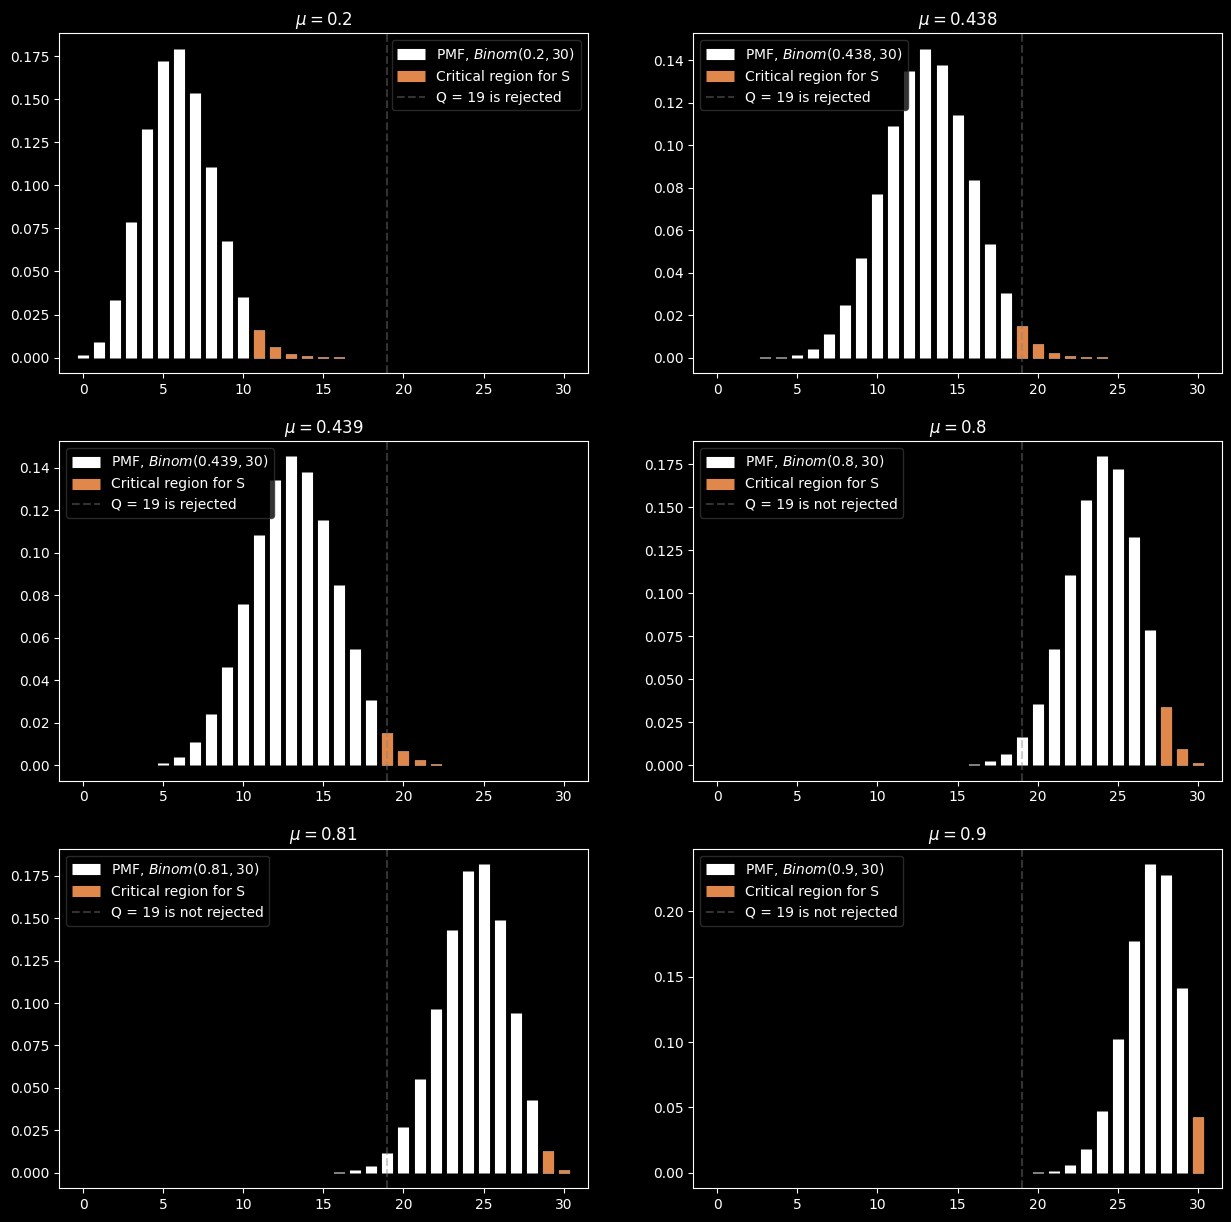

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for mu_h0, ax in zip(mus_h0, axes.flatten()):
    binom_h0 = binom(n=30, p=mu_h0)
    probs = binom_h0.pmf(x_grid)

    # строим вертикальные столбцы от 0 до вероятности
    ax.vlines(x_grid, 0, probs, linewidth=8.0, color='white', label=f'PMF, $Binom({mu_h0}, 30)$')
    # отдельно изобразим критическую области критерия
    c = make_binom_criterion(30, mu_h0, alpha=0.05)
    crit_reg = (x_grid > c)
    ax.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=8.0, label='Critical region for S')

    is_rejection = success_cnt >= c
    ax.axvline(success_cnt, ls='--', label=f'Q = {success_cnt} ' + ('is rejected' if is_rejection else 'is not rejected'), color='gray', alpha=0.4)

    rejection_prob = probs[crit_reg].sum()
    ax.set_title(f'$\\mu = {mu_h0}$', fontsize=12)
    ax.legend()

Теперь мы с правой стороны графика плотности распределения убираем в 2 раза больше площади, поэтому чтобы получить такую же точность, но с двусторонним интервалом, достаточно просто увеличить $\alpha$ в два раза

In [105]:
n = 30
success_cnt = 19
mu_grid = np.arange(0, 1, 0.001)
mu_no_rejected = []

for mu_h0 in mu_grid:
    left, right = get_interval(n, mu_h0, alpha=0.1)
    if left <= success_cnt <= right:
        mu_no_rejected.append(mu_h0)
print(mu_no_rejected[0], mu_no_rejected[-1])

0.467 0.778


В Python реализованы функции, которые считают доверительный интервал быстрее, но менее точно